In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [5]:
# Data Loader
csf_data = pd.read_csv("csf_demo_data.csv", low_memory=False)

In [6]:
csf_data['Status_at_draw_mapping'].value_counts()

Status_at_draw_mapping
CO     10
AD     10
PD     10
DLB    10
FTD    10
Name: count, dtype: int64

In [8]:
csf_significant_rows = pd.read_csv("csf_significant_rows_0205.csv")

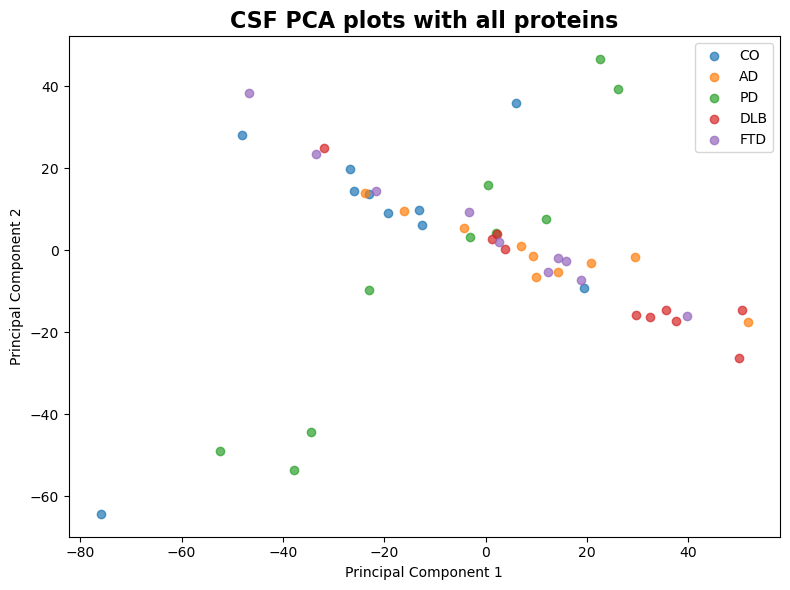

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Make a copy of the CSF dataset (can switch to plasma_data if needed)
data = csf_data.copy()
# data = plasma_data.copy()

# Select only columns that start with 'X' (protein features), plus the label column
x_cols = [col for col in data.columns if col.startswith('X')]
x_cols.append('Status_at_draw_mapping')  # This is assumed to be your target/label column
data = data[x_cols]

# Drop rows with missing values in the label column
data = data.dropna(subset=['Status_at_draw_mapping'])

# Separate features and labels
features = data.iloc[:, :-1]  # all 'X'-prefixed columns
labels = data.iloc[:, -1]     # last column: 'Status_at_draw_mapping'

# Define a bootstrap imputation function to fill missing values in each column
def bootstrap_impute(df):
    df_filled = df.copy()
    for col in df.columns:
        missing = df_filled[col].isna()
        observed_values = df_filled.loc[~missing, col]
        if not observed_values.empty:
            # Randomly sample from observed values to fill the missing ones
            df_filled.loc[missing, col] = np.random.choice(observed_values, size=missing.sum(), replace=True)
    return df_filled

# Apply bootstrap imputation to the features
features_imputed = bootstrap_impute(features)

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_imputed)

# Create a DataFrame to store PCA results and labels
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Status_at_draw_mapping'] = labels.values

# Plot the PCA results, coloring by label
plt.figure(figsize=(8,6))
for status in pca_df['Status_at_draw_mapping'].unique():
    subset = pca_df[pca_df['Status_at_draw_mapping'] == status]
    plt.scatter(subset['PC1'], subset['PC2'], label=status, alpha=0.7)

# Plot formatting
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('CSF PCA plots with all proteins', weight='bold', size=16)
plt.legend()
plt.tight_layout()
plt.show()


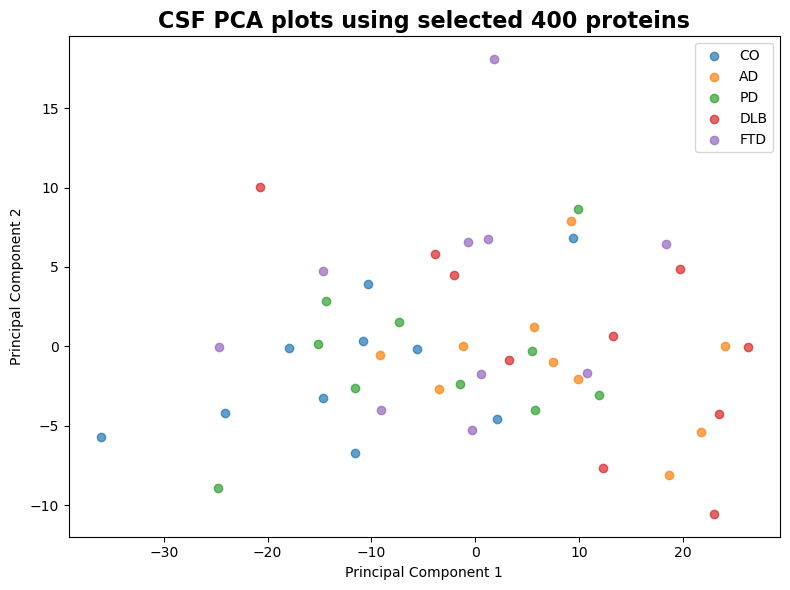

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === 0. Load the feature list ===
# features_path = "plasma_model_output/plasma_selected_features_700_0411.txt"
features_path = "csf_model_output/csf_selected_features_400_0411.txt"
with open(features_path, "r") as f:
    selected_feature_list = [line.strip() for line in f.readlines()]

# === 1. Load original data and filter relevant columns ===
# data = plasma_data.copy()  # or csf_data.copy() if working on CSF
data = csf_data.copy()

# Ensure target label is included
selected_feature_list_with_label = selected_feature_list + ['Status_at_draw_mapping']

# Drop rows where label is missing
data = data[selected_feature_list_with_label].dropna(subset=['Status_at_draw_mapping'])

# Separate features and labels
X = data[selected_feature_list]
y = data['Status_at_draw_mapping']

# === 2. Fill missing values using bootstrap imputation ===
def bootstrap_impute(df):
    df_filled = df.copy()
    for col in df.columns:
        missing = df_filled[col].isna()
        observed = df_filled.loc[~missing, col]
        if not observed.empty:
            df_filled.loc[missing, col] = np.random.choice(observed, size=missing.sum(), replace=True)
    return df_filled

X_imputed = bootstrap_impute(X)

# === 3. PCA Transformation ===
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_imputed)

# Build a PCA result DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Status_at_draw_mapping'] = y.values

# === 4. Visualization ===
plt.figure(figsize=(8, 6))

# Plot by each group in Status_at_draw_mapping
for status in pca_df['Status_at_draw_mapping'].unique():
    subset = pca_df[pca_df['Status_at_draw_mapping'] == status]
    plt.scatter(subset['PC1'], subset['PC2'], label=status, alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('CSF PCA plots using selected 400 proteins', weight='bold', size=16)
plt.legend()
plt.tight_layout()
plt.show()


### Data Loader

In [11]:
data = csf_data.copy()
print(data.shape)

(50, 3667)


In [12]:
x_columns = [col for col in csf_data.columns if col.startswith('X')]
len(x_columns)

3622

In [13]:
protein_list = list(csf_significant_rows['Analytes'])
print(len(protein_list))
# protein_list

3020


In [14]:
data['Status_at_draw_mapping'].value_counts()

Status_at_draw_mapping
CO     10
AD     10
PD     10
DLB    10
FTD    10
Name: count, dtype: int64

In [15]:
data['Project_y'].value_counts()

Project_y
Pau     13
MAP     11
PPMI    11
Ruiz     8
PD       5
ADNI     2
Name: count, dtype: int64

In [16]:
statuses_to_keep = ['CO', 'AD', 'PD', 'FTD', 'DLB']

filtered_data = data[data['Status_at_draw_mapping'].isin(statuses_to_keep)]
 
filtered_data.shape

(50, 3667)

In [17]:
filtered_data['Project_y'].value_counts()

Project_y
Pau     13
MAP     11
PPMI    11
Ruiz     8
PD       5
ADNI     2
Name: count, dtype: int64

In [18]:
filtered_data['Status_at_draw_mapping'].value_counts()

Status_at_draw_mapping
CO     10
AD     10
PD     10
DLB    10
FTD    10
Name: count, dtype: int64

In [19]:
filtered_data = filtered_data.rename(columns={'final_decision': 'PET_imaging'})

columns_to_keep = ['UniquePhenoID', 'DrawDate', 'Project_x', 'Project_y', 'Age_at_draw', 'Sex', 'AT_class', 'PET_imaging', 'T1_pTau217',
       'T2_pTau181', 'Status_at_draw_mapping', 'Status_at_draw', 'Final_Status']
print(columns_to_keep)

selected_protein_columns = [col for col in data.columns if col in protein_list]

selected_columns = list(columns_to_keep) + selected_protein_columns

selected_data = filtered_data[selected_columns]

selected_data.shape

['UniquePhenoID', 'DrawDate', 'Project_x', 'Project_y', 'Age_at_draw', 'Sex', 'AT_class', 'PET_imaging', 'T1_pTau217', 'T2_pTau181', 'Status_at_draw_mapping', 'Status_at_draw', 'Final_Status']


(50, 3033)

In [20]:
# Check which columns contain non-float values
non_float_columns = selected_data.iloc[:,13:].applymap(lambda x: isinstance(x, (float, int))).all() == False
non_float_columns_indices = non_float_columns[non_float_columns].index

if not non_float_columns_indices.empty:
    print(f"Columns with non-float values: {list(non_float_columns_indices)}")
else:
    print("All columns are float type.")

All columns are float type.


C:\Users\x.ying1\AppData\Local\Temp\ipykernel_31996\3170815002.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_float_columns = selected_data.iloc[:,13:].applymap(lambda x: isinstance(x, (float, int))).all() == False


In [21]:
# Check for NA values in selected_data
na_counts = selected_data.iloc[:,13:].isna().sum()

# Get columns with NA values
na_columns = na_counts[na_counts > 0]

# Print the total number of NA values and columns with NA values
total_na = na_counts.sum()
print(f"Total number of NA values in selected_data: {total_na}")
if not na_columns.empty:
    print("Columns with NA values and their counts:")
    print(na_columns)
else:
    print("No NA values in selected_data.")

Total number of NA values in selected_data: 4208
Columns with NA values and their counts:
X10521.10     2
X5648.28      1
X9333.59      2
X5888.29      5
X13969.24     2
             ..
X8840.61      1
X3030.3       1
X12551.3      2
X9898.161     1
X12904.180    2
Length: 2134, dtype: int64


In [22]:
import numpy as np

np.random.seed(42)

def bootstrap_impute(series):
    observed = series.dropna()
    n_missing = series.isna().sum()
    if n_missing > 0 and len(observed) > 0:
        imputed_values = np.random.choice(observed, size=n_missing, replace=True)
        series.loc[series.isna()] = imputed_values
    return series

num_cols = selected_data.columns[13:]

selected_data[num_cols] = (
    selected_data.groupby("Status_at_draw", group_keys=False)[num_cols]
    .apply(lambda g: g.apply(bootstrap_impute, axis=0))
)

selected_data[num_cols] = selected_data[num_cols].fillna(selected_data[num_cols].median())

na_counts_after = selected_data[num_cols].isna().sum()
total_na_after = na_counts_after.sum()
print(f"Total number of NA values in selected_data after filling: {total_na_after}")

if not na_counts_after[na_counts_after > 0].empty:
    print("Columns with remaining NA values and their counts:")
    print(na_counts_after[na_counts_after > 0])
else:
    print("No NA values in selected_data after filling.")

C:\Users\x.ying1\AppData\Local\Temp\ipykernel_31996\2335237837.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data[num_cols] = (
C:\Users\x.ying1\AppData\Local\Temp\ipykernel_31996\2335237837.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data[num_cols] = selected_data[num_cols].fillna(selected_data[num_cols].median())


Total number of NA values in selected_data after filling: 0
No NA values in selected_data after filling.


#### LightGBM

In [23]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import numpy as np
import pandas as pd
from scipy.stats import zscore

np.random.seed(42)

X = selected_data.iloc[:, 13:]
print(X.shape)

y = selected_data['Status_at_draw_mapping']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

variance_filter = VarianceThreshold(threshold=0.01)
X_filtered = variance_filter.fit_transform(X)
print(X_filtered.shape)

k_best_selector = SelectKBest(score_func=f_classif, k=min(400, X_filtered.shape[1]))
# k_best_selector = SelectKBest(score_func=f_classif, k=min(700, X_filtered.shape[1]))
X_selected = k_best_selector.fit_transform(X_filtered, y_encoded)
print(X_selected.shape)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

lgbm_model = LGBMClassifier(
    n_estimators=300, max_depth=20, learning_rate=0.05, random_state=42,
    # n_estimators=400, max_depth=20, learning_rate=0.05, random_state=42,
    min_child_samples=10, min_split_gain=0.0, objective='multiclass', metric='multi_logloss',
    force_col_wise=True
)

lgbm_model.fit(X_train_resampled, y_train_resampled)

class_labels = label_encoder.inverse_transform(np.unique(y_encoded))
print("Class Labels:", class_labels)

# Prediction
y_pred = lgbm_model.predict(X_test)
y_pred_proba = lgbm_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")

auc_ovr_weighted = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="weighted")
auc_ovr_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
auc_ovo_weighted = roc_auc_score(y_test, y_pred_proba, multi_class="ovo", average="weighted")
auc_ovo_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovo", average="macro")

(50, 3020)
(50, 3020)
(50, 400)
[LightGBM] [Info] Total Bins 3966
[LightGBM] [Info] Number of data points in the train set: 25, number of used features: 400
[LightGBM] [Info] Start training from score -1.832581
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.427116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [24]:
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Balanced Accuracy: {balanced_acc * 100:.2f}%")
print(f"Macro F1-score: {f1_macro:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print(f"OvR AUC Weighted: {auc_ovr_weighted:.4f}")
print(f"OvR AUC Macro: {auc_ovr_macro:.4f}")
print(f"OvO AUC Weighted: {auc_ovo_weighted:.4f}")
print(f"OvO AUC Macro: {auc_ovo_macro:.4f}")

Accuracy: 40.00%
Balanced Accuracy: 40.00%
Macro F1-score: 0.3358
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         3
           1     0.3333    0.3333    0.3333         3
           2     0.5000    0.3333    0.4000         3
           3     0.5000    0.3333    0.4000         3
           4     0.3750    1.0000    0.5455         3

    accuracy                         0.4000        15
   macro avg     0.3417    0.4000    0.3358        15
weighted avg     0.3417    0.4000    0.3358        15

OvR AUC Weighted: 0.8111
OvR AUC Macro: 0.8111
OvO AUC Weighted: 0.8111
OvO AUC Macro: 0.8111


C:\Users\x.ying1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\x.ying1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\x.ying1\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [25]:
# ================================
# >>> Set data source here:
# ================================
# data_source = "CSF"   # or "Plasma"
data_source = "CSF"

# ============================================================
# >>> 1) Get feature names that survived both filters
# ============================================================
feat_after_var         = X.columns[variance_filter.get_support()]      # kept by VarianceThreshold
selected_feature_names = feat_after_var[k_best_selector.get_support()] # kept by SelectKBest

# ============================================================
# >>> 2) Map analyte IDs to EntrezGeneSymbol (CSF or Plasma)
#      and rename features as: Analyte_EntrezGeneSymbol
# ============================================================
import pandas as pd
import shap
import matplotlib.pyplot as plt

# Load the relevant sheet
mapping_df = pd.read_excel("Analyte_mapping.xlsx", sheet_name=data_source)
mapping_df = mapping_df.loc[:, ["Analytes", "EntrezGeneSymbol"]].dropna()
analyte2gene = dict(zip(mapping_df["Analytes"].astype(str), mapping_df["EntrezGeneSymbol"]))

# Combine original analyte ID and gene symbol into one name: "X1234_ACHE"
mapped_feature_names = []
for analyte in selected_feature_names:
    gene_symbol = analyte2gene.get(analyte, None)
    if gene_symbol is not None:
        mapped_feature_names.append(f"{analyte}_{gene_symbol}")
    else:
        mapped_feature_names.append(analyte)  # fallback if not mapped

# Update feature names in X_test
X_test_df = pd.DataFrame(X_test, columns=mapped_feature_names)
selected_feature_names = mapped_feature_names  # for downstream plots and CSV

# ============================================================
# >>> 3) SHAP explanation and beeswarm plots
# ============================================================
shap.initjs()

explainer      = shap.Explainer(lgbm_model)
shap_exp       = explainer(X_test_df)
shap_values_3d = shap_exp.values  # shape: (n_samples, n_features, n_classes)

for idx, label in enumerate(class_labels):
    sv = shap_values_3d[:, :, idx]  # (n_samples, n_features) for this class

    print(f"\nSHAP summary for class {label}:")
    shap.summary_plot(
        sv,
        X_test_df,
        feature_names=selected_feature_names,
        max_display=20,
        show=False
    )
    plt.title(f"SHAP summary – {label} ({data_source})")
    plt.savefig(f"SHAP_summary_{data_source}_{label}.png", dpi=300, bbox_inches="tight")
    plt.close()

# ============================================================
# >>> 4) SHAP Importance (Global + Per-Class) ➜ Save to CSV
# ============================================================

# Dictionary to hold mean(|SHAP|) values for each class
per_class_shap = {}

# Loop through each class and compute mean absolute SHAP values across samples
# Resulting shape for each: (n_features,)
for idx, label in enumerate(class_labels):
    sv = shap_values_3d[:, :, idx]  # SHAP values for this class
    per_class_shap[label] = np.abs(sv).mean(axis=0)

# Compute the global mean(|SHAP|) across all classes and all samples
mean_abs_shap_global = np.abs(shap_values_3d).mean(axis=(0, 2))

# Initialize DataFrame with feature names and global SHAP values
shap_rank_df = pd.DataFrame({
    "Feature": selected_feature_names,
    "Mean|SHAP|_Global": mean_abs_shap_global
})

# Add one column for each class-specific mean(|SHAP|) value
for label in class_labels:
    shap_rank_df[f"Mean|SHAP|_{label}"] = per_class_shap[label]

# Sort by global SHAP importance in descending order
shap_rank_df = shap_rank_df.sort_values("Mean|SHAP|_Global", ascending=False).reset_index(drop=True)

# Save results to CSV file
csv_name = f"SHAP_feature_importance_{data_source}_per_class.csv"
shap_rank_df.to_csv(csv_name, index=False)

# Print confirmation of saved files
print("\n>>> Saved:")
for label in class_labels:
    print(f" • SHAP_summary_{data_source}_{label}.png")
print(f" • {csv_name}")




SHAP summary for class AD:


C:\Users\x.ying1\AppData\Local\Temp\ipykernel_31996\2253837093.py:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



SHAP summary for class CO:


C:\Users\x.ying1\AppData\Local\Temp\ipykernel_31996\2253837093.py:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



SHAP summary for class DLB:


C:\Users\x.ying1\AppData\Local\Temp\ipykernel_31996\2253837093.py:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



SHAP summary for class FTD:


C:\Users\x.ying1\AppData\Local\Temp\ipykernel_31996\2253837093.py:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



SHAP summary for class PD:


C:\Users\x.ying1\AppData\Local\Temp\ipykernel_31996\2253837093.py:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



>>> Saved:
 • SHAP_summary_CSF_AD.png
 • SHAP_summary_CSF_CO.png
 • SHAP_summary_CSF_DLB.png
 • SHAP_summary_CSF_FTD.png
 • SHAP_summary_CSF_PD.png
 • SHAP_feature_importance_CSF_per_class.csv


In [26]:
# import joblib
# import os

# save_dir = "plasma_model_output"
# os.makedirs(save_dir, exist_ok=True)

# model_path = os.path.join(save_dir, "plasma_lgbm_model_700_0411.pkl")
# joblib.dump(lgbm_model, model_path)

# # label_encoder_path = os.path.join(save_dir, "label_encoder.pkl")
# # joblib.dump(label_encoder, label_encoder_path)

# # variance_filter_path = os.path.join(save_dir, "variance_filter.pkl")
# # joblib.dump(variance_filter, variance_filter_path)

# # k_best_selector_path = os.path.join(save_dir, "k_best_selector.pkl")
# # joblib.dump(k_best_selector, k_best_selector_path)

# selected_feature_names = X.columns[variance_filter.get_support()][k_best_selector.get_support()]
# feature_names_path = os.path.join(save_dir, "plasma_selected_features_700_0411.txt")

# with open(feature_names_path, "w") as f:
#     for feature in selected_feature_names:
#         f.write(feature + "\n")

# print(f"Model and processing components saved in {save_dir}")